In [1]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#tqdm.pandas()
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [4]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')

In [5]:
with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [7]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


In [41]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id',] #'click_environment','click_deviceGroup']
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [42]:
user_clicks = get_click_data()

In [43]:
user_clicks.to_csv('data/user_clicks.csv')

In [357]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


user_id             322897
click_article_id     46033
dtype: int64

# Train/Test Split

Smaller samples are used for GD optimization and testing.

Larger samples are used for validation.

In [45]:
def train_test_split(df, size, leftover_size):
    start = time()
    df = df[df.groupby('user_id').user_id.transform(len) >= (size + leftover_size)]
    print(time() - start, 'seconds to filter down dataframe')
    
    start = time()
    df_train = df.groupby('user_id').apply(lambda x: x.sample(8)) #.reset_index(drop=True)
    print(time() - start, 'seconds to sub-sample dataframe')
    
    start = time()
    df_test = df[~df.index.isin(df_train.index)]
    print(time() - start, 'seconds to get df_test')
    
    return df_train, df_test

In [384]:
df_train, df_test = train_test_split(user_clicks,8,2)

95.36949682235718 seconds to filter down dataframe
37.521403074264526 seconds to sub-sample dataframe
959.681871175766 seconds to get df_test


In [387]:
df_sample = df_train[0:1600]

In [161]:
df_sample_test = df_test[df_test.user_id.isin(df_test.user_id.unique()[0:200])]

In [163]:
df_train.to_csv('data/df_train.csv')
df_test.to_csv('data/df_test.csv')
df_sample.to_csv('data/df_sample.csv')
df_sample_test.to_csv('data/df_sample_test.csv')

In [177]:
print(df_train.shape)
print(df_test.shape)
print(df_sample.shape)
print(df_sample_test.shape)

(683208, 4)
(2027773, 3)
(1600, 4)
(8265, 3)


In [46]:
## Bigger Size
df_train_big, df_test_big = train_test_split(user_clicks,20,10)

90.52367687225342 seconds to filter down dataframe
7.350966930389404 seconds to sub-sample dataframe
0.27716588973999023 seconds to get df_test


In [47]:
# df_train_big.to_csv('data/df_train_big.csv')
# df_test_big.to_csv('data/df_test_big.csv')

In [48]:
# #read back
# df_train_big = pd.read_csv('data/df_train_big.csv')

### Read Back

In [6]:
df_train = pd.read_csv('data/df_train.csv',index_col=0)
df_test = pd.read_csv('data/df_test.csv',index_col=0)

In [6]:
df_sample = pd.read_csv('data/df_sample.csv')
df_sample_test = pd.read_csv('data/df_sample_test.csv',index_col=0)

# Models 1 & 2: Linear and Nonlinear Factorization

In [7]:
from model import *

### 1 Interest Unit

304.42211413383484 seconds


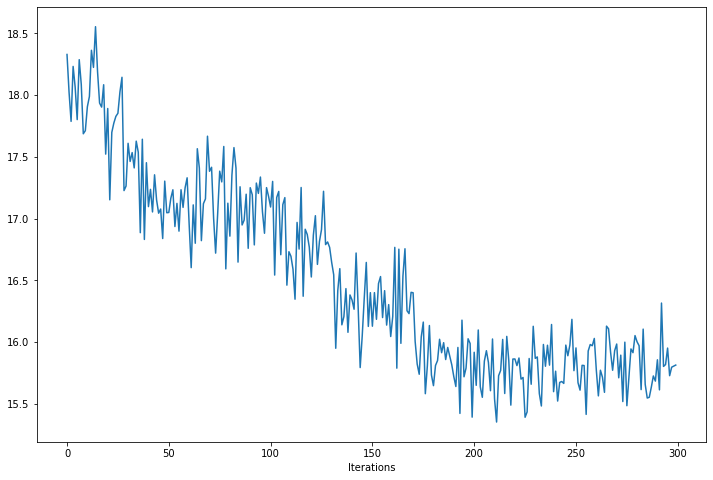

In [62]:
lm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
start = time()
lm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=300,
    test_size=128,
    hinge_param = 1,
)
print(time() - start, 'seconds')

365.6963782310486 seconds


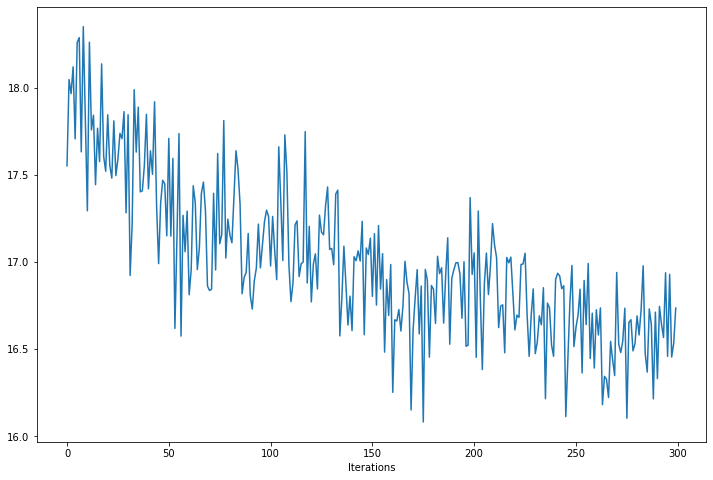

In [120]:
lm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
start = time()
lm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=300,
    test_size=128,
    hinge_param = 1,
)
print(time() - start, 'seconds')

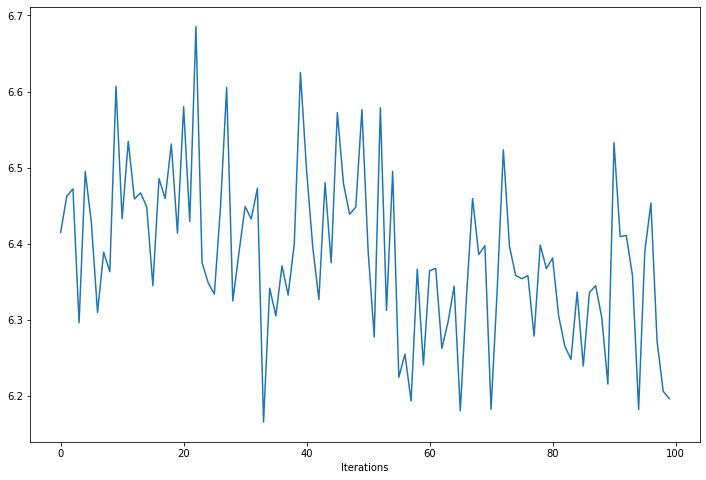

In [8]:
#starthere

nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=100,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

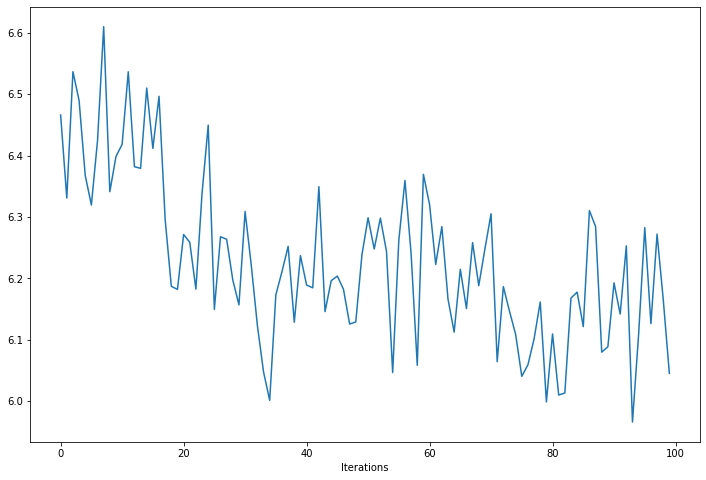

In [9]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=100,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

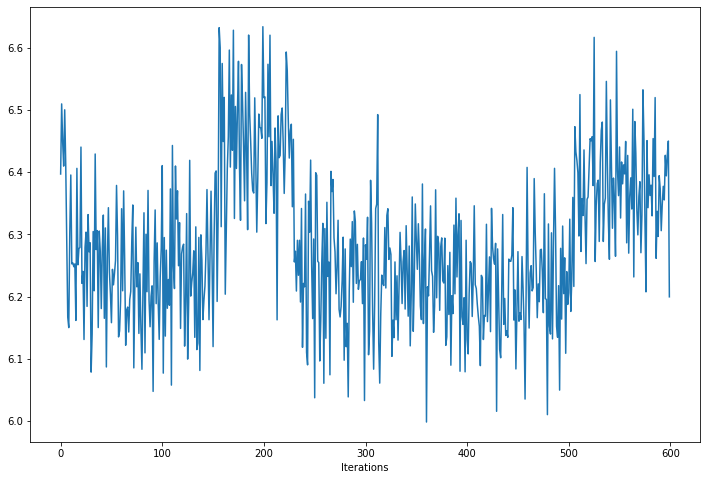

In [10]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

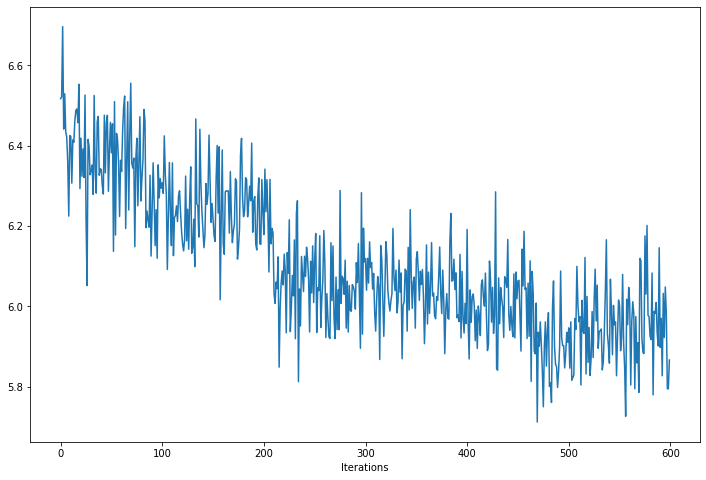

In [11]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

#non-normalized U at beginning

In [23]:
from model import *

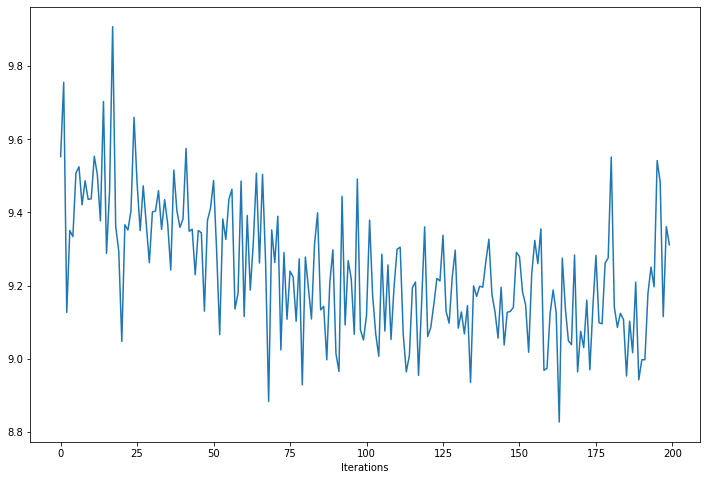

In [8]:
#normalized U
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=2,
    norm_U=True
)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=200,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
)

## 2 Interest Units

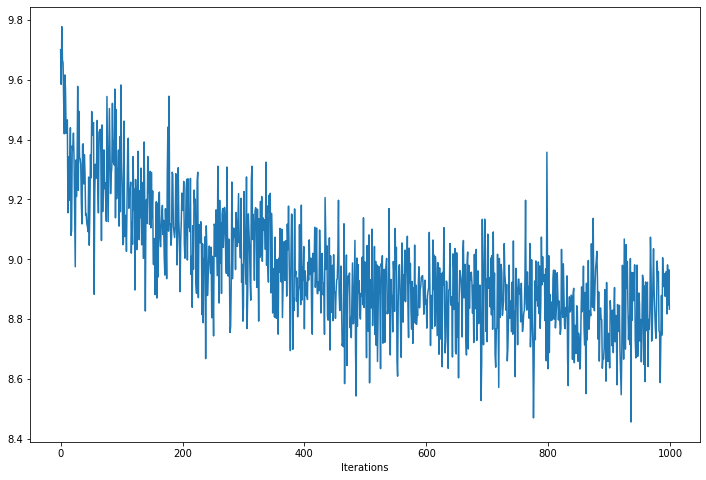

In [11]:
#normalized U
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=2,
    norm_U=True
)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
)

## 3 Interest Units

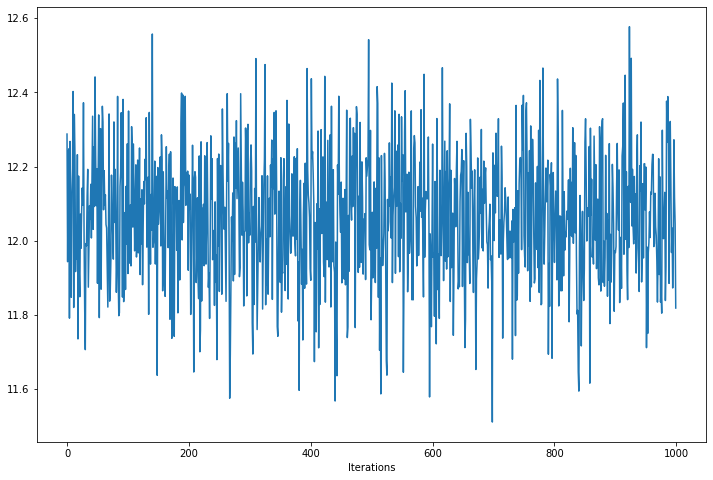

In [14]:
#normalized U
nm3 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=3,
    norm_U=True
)
nm3.gradient_descent_nonlinear(
    test=True,
    alpha=0.05,
    max_iterations=1000,
    test_size=64,
    batch_size=48,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
)

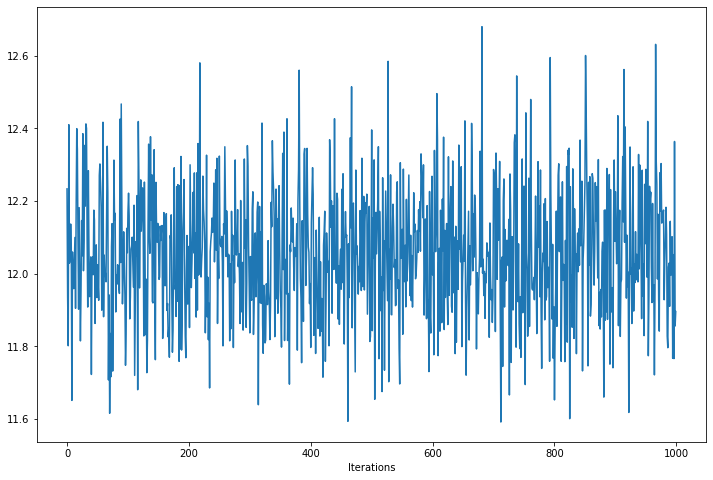

In [15]:
#normalized U
nm3 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=3,
    norm_U=True
)
nm3.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=1000,
    test_size=64,
    batch_size=48,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
)

In [9]:
nm2.U.shape

(200, 2, 250)

In [10]:
nm2.U[0,0,0:10]

array([-0.05353684, -0.18566418, -0.07887419, -0.07453242, -0.05906555,
       -0.03153152, -0.02533018,  0.02606188,  0.05121594, -0.01677049],
      dtype=float32)

In [15]:
np.max([[0,0,0],[-1,2,3]],axis=0)

array([0, 2, 3])

In [9]:
np.sum([[1,2],[3,4]])

10

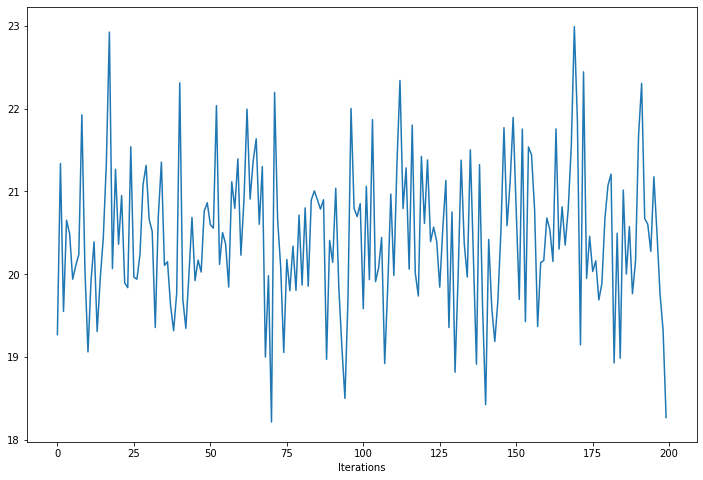

In [20]:
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=200,
    test_size=16,
    batch_size=16,
    hinge_param = 1,
    readj_interval=20,
    #gd_algorithm='rprop'
)

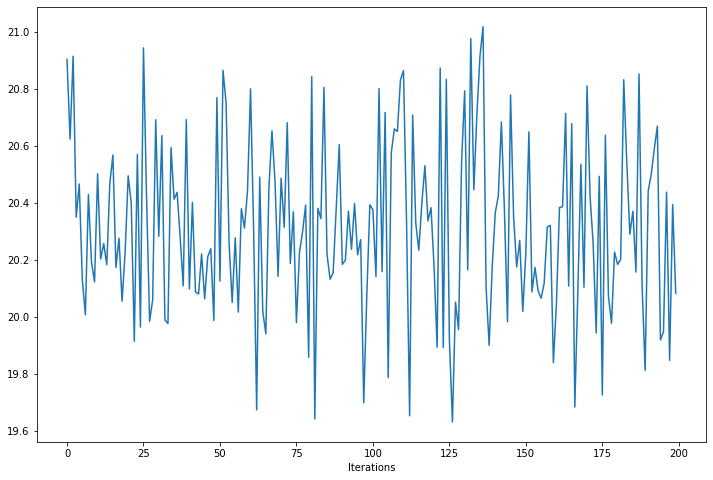

In [35]:
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.0001,
    max_iterations=200,
    test_size=128,
    batch_size=16,
    hinge_param = 1,
    readj_interval=20,
    #gd_algorithm='rprop'
)

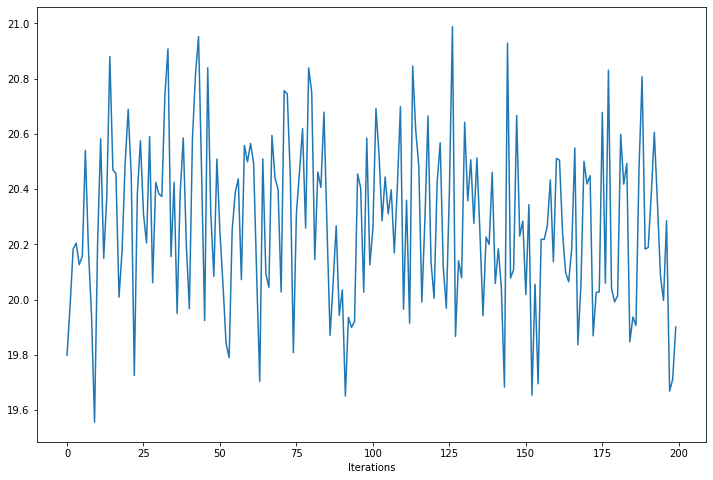

In [36]:
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.0001,
    max_iterations=200,
    test_size=128,
    batch_size=16,
    hinge_param = 0,
    readj_interval=20,
    #gd_algorithm='rprop'
)

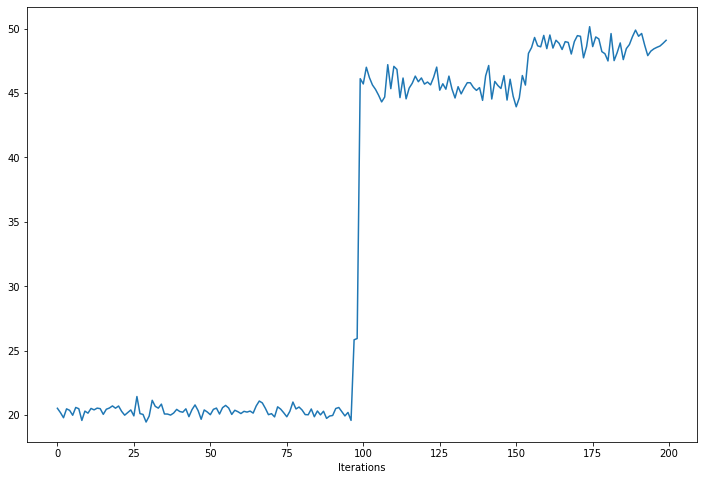

In [37]:
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=1,
    max_iterations=200,
    test_size=128,
    batch_size=16,
    hinge_param = 0,
    readj_interval=20,
    #gd_algorithm='rprop'
)

In [ ]:
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.00025,
    max_iterations=2000,
    test_size=128,
    batch_size=16,
    hinge_param = 1,
    readj_interval=50,
    #gd_algorithm='rprop'
)

In [7]:
from sklearn.decomposition import PCA

In [8]:
#start here
pca = PCA(n_components=50)
df_sample = pd.read_csv('data/df_sample.csv')
df_sample_test = pd.read_csv('data/df_sample_test.csv',index_col=0)

In [12]:
embeddings_50 = pca.fit_transform(embeddings)

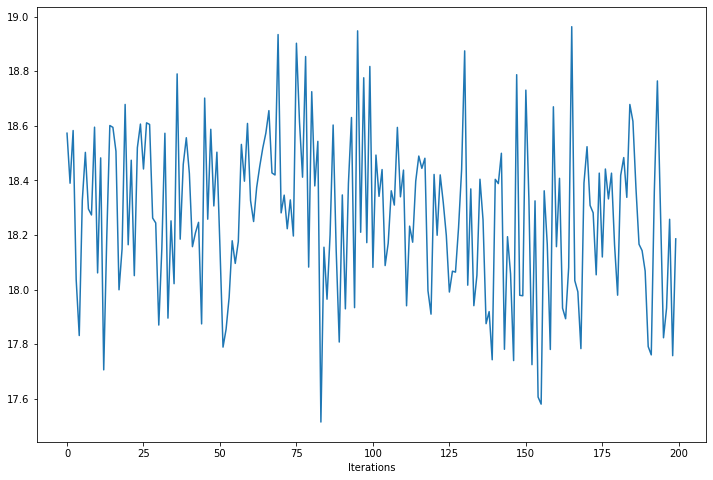

In [10]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=200,
    test_size=64,
    batch_size=32,
    hinge_param = 1,
    readj_interval=1,
    #gd_algorithm='rprop'
)

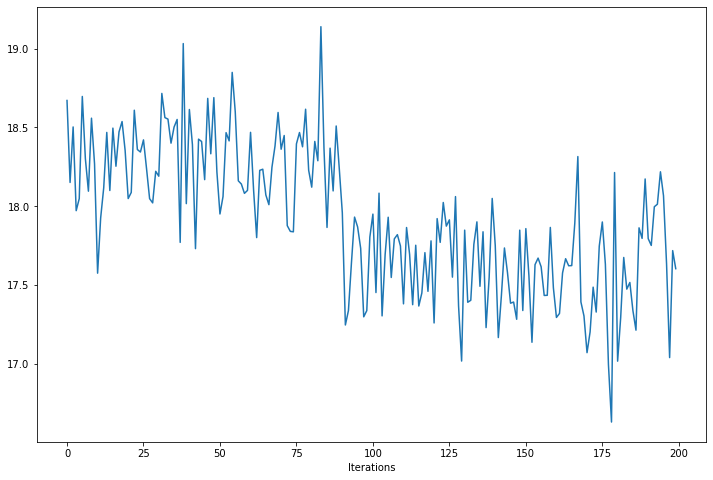

In [13]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.5,
    max_iterations=200,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

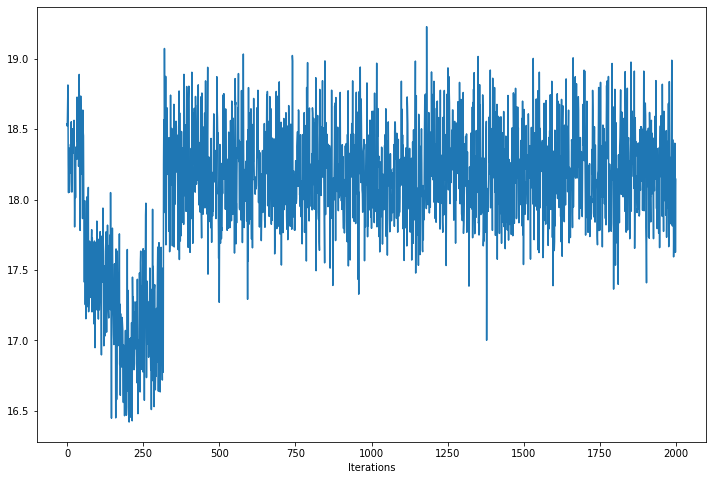

In [14]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.5,
    max_iterations=2000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

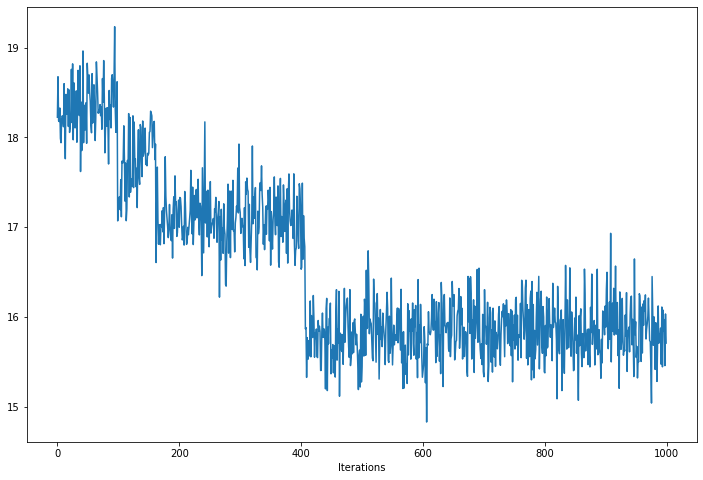

In [15]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

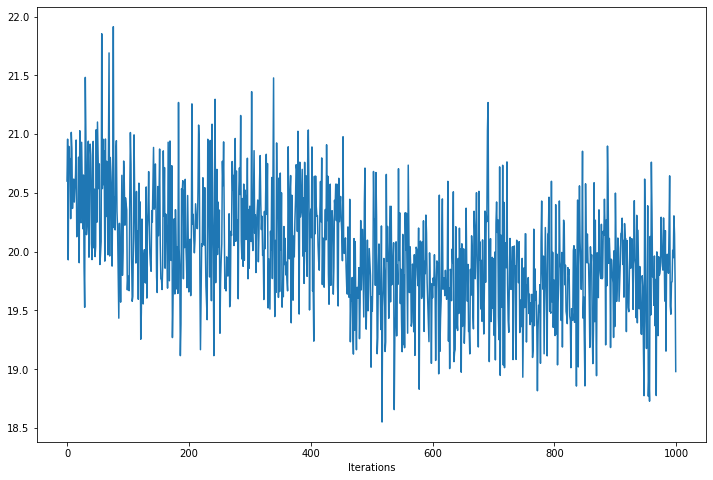

In [22]:
nm2 = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

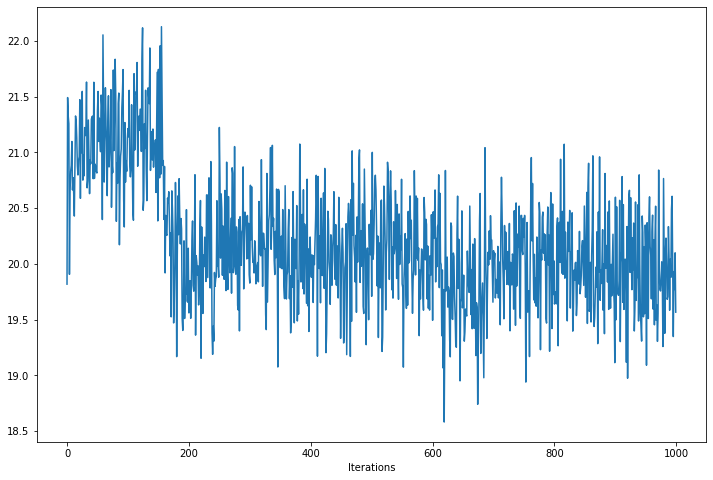

In [23]:
nm2 = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.5,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

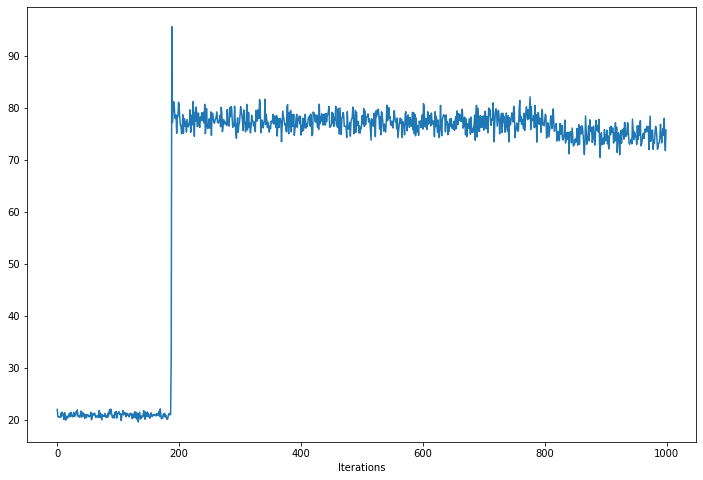

In [24]:
nm2 = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=2.5,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

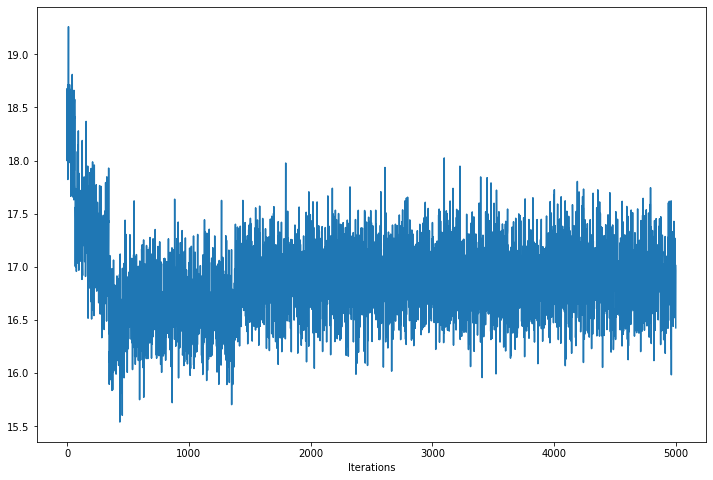

In [25]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=5000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    #gd_algorithm='rprop'
)

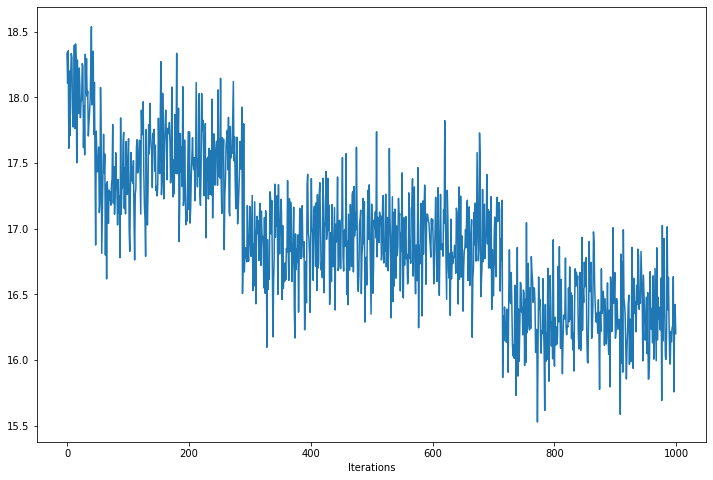

In [39]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

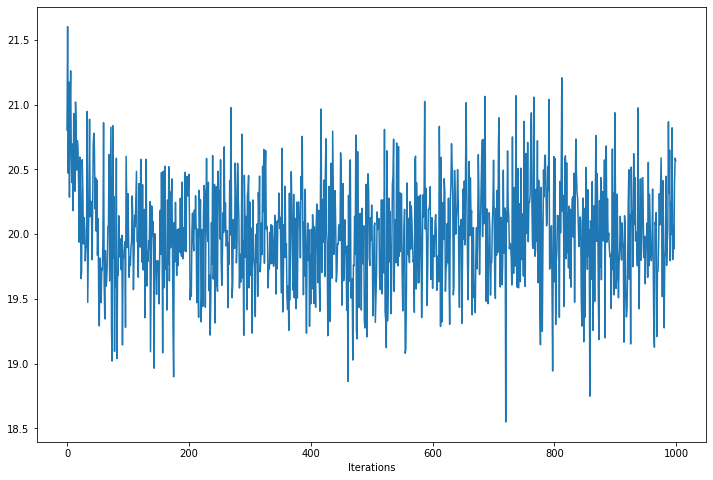

In [40]:
nm2 = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.2,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

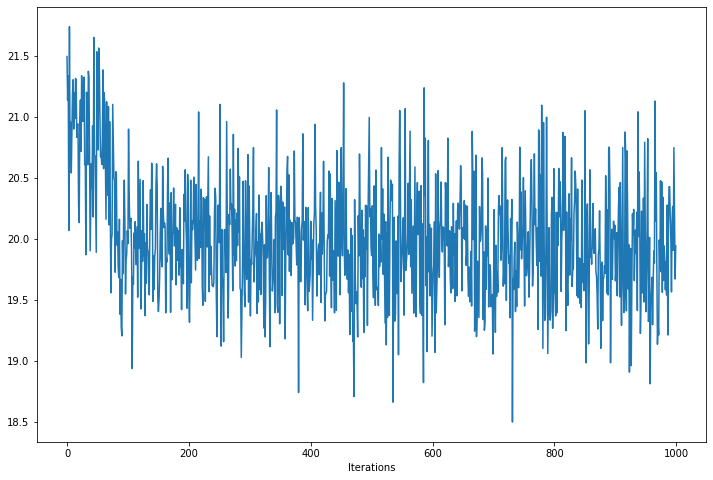

In [42]:
nm2 = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.15,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

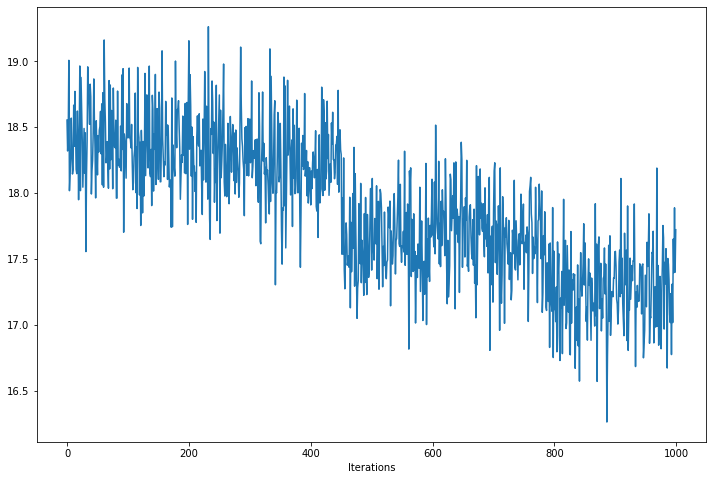

In [44]:
nm2 = NonlinearModel(
    df_sample,
    PCA(n_components=100).fit_transform(embeddings),
    size=8, 
    embeddings_size=100, 
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.15,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

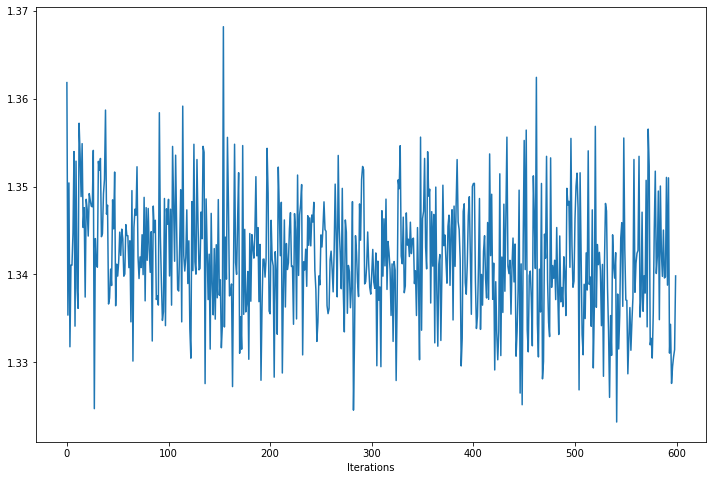

In [49]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings,norm='l2'),
    size=8, 
    embeddings_size=250, 
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

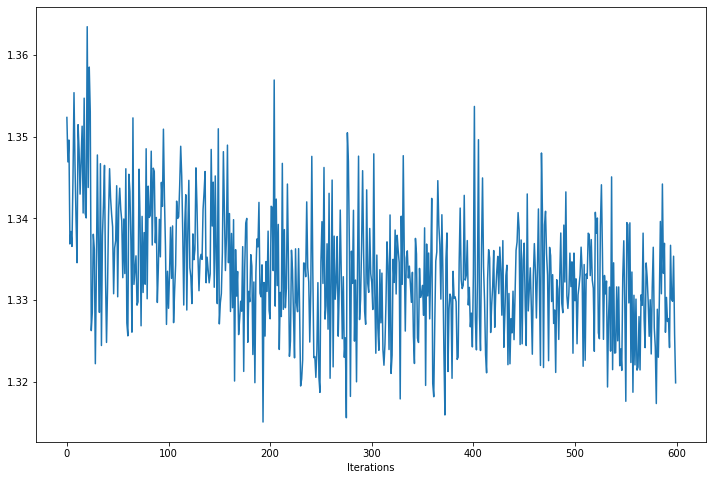

In [50]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings,norm='l2'),
    size=8, 
    embeddings_size=250, 
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

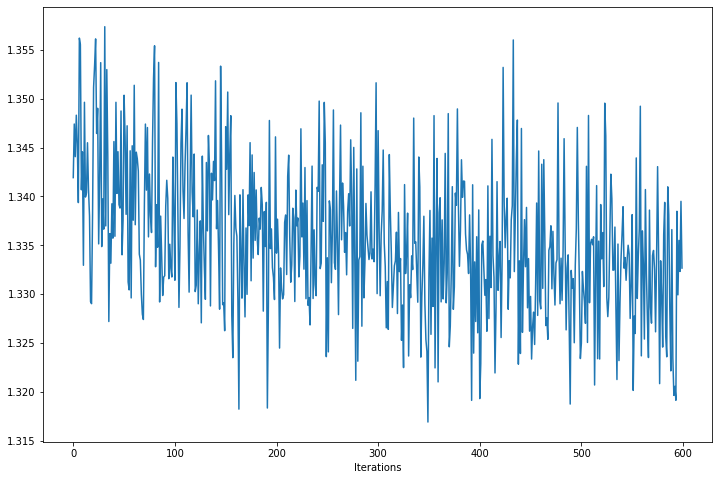

In [52]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings,norm='l2'),
    size=8, 
    embeddings_size=250, 
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=600,
    test_size=64,
    batch_size=64,
    hinge_param = 0,
    readj_interval=1,
)

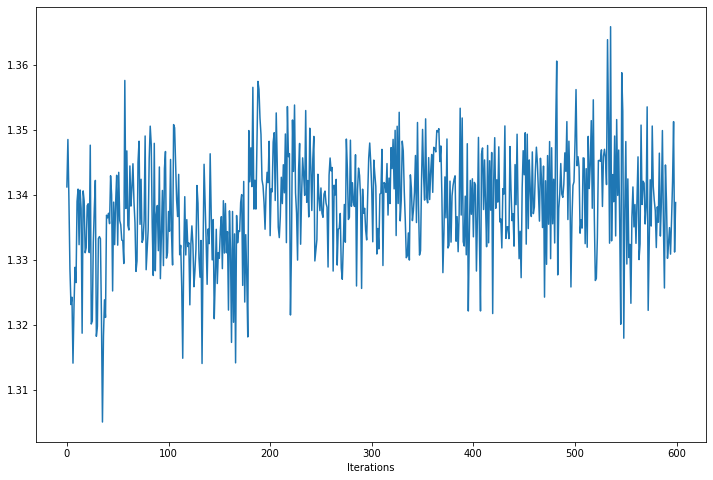

In [51]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings,norm='l2'),
    size=8, 
    embeddings_size=250, 
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.5,
    max_iterations=600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

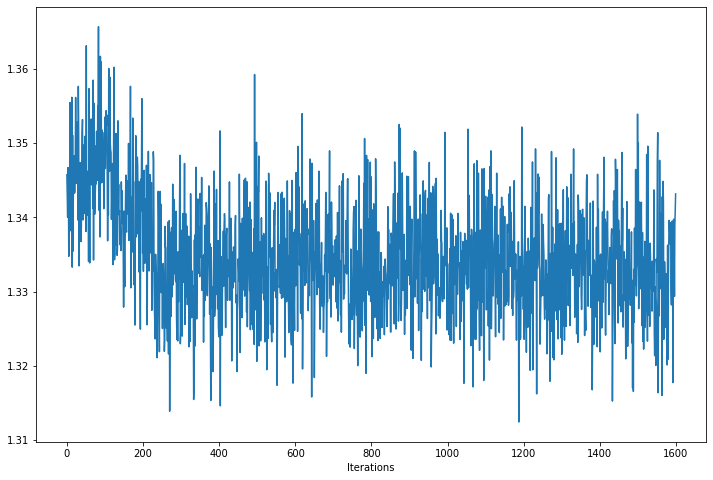

In [54]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings,norm='l2'),
    size=8, 
    embeddings_size=250, 
    T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.2,
    max_iterations=1600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

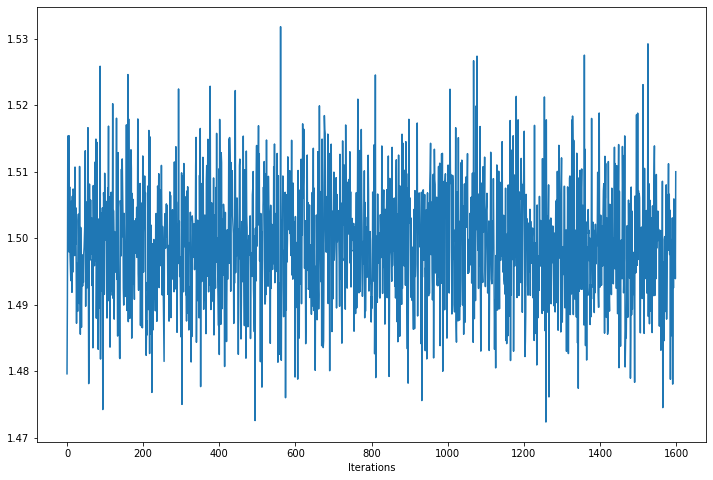

In [56]:
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings,norm='l2'),
    size=8, 
    embeddings_size=250, 
    T=3)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=1600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
)

In [41]:
np.linalg.norm(embeddings[0:100],axis=1)

array([7.608626 , 8.051851 , 7.6905475, 8.325726 , 7.947334 , 8.244961 ,
       7.550861 , 7.996746 , 7.583215 , 7.9156804, 8.791225 , 9.093318 ,
       8.716789 , 9.2411   , 8.389892 , 8.830697 , 8.611397 , 8.41568  ,
       8.386547 , 9.419254 , 9.226734 , 8.4425955, 7.3272133, 7.539846 ,
       8.8119755, 8.0255785, 7.3055463, 8.436738 , 7.915697 , 6.0601068,
       6.348195 , 8.066988 , 7.967505 , 6.322904 , 5.966573 , 7.8977203,
       8.334353 , 7.441736 , 7.4337025, 8.144368 , 7.507958 , 5.721378 ,
       7.082997 , 8.091837 , 7.856242 , 8.835823 , 8.941711 , 7.9809375,
       6.5395594, 7.3316846, 7.2263756, 8.106984 , 6.139766 , 7.169573 ,
       8.306982 , 8.307556 , 9.009641 , 8.154507 , 7.0293107, 7.1357245,
       6.811307 , 7.3920703, 7.577029 , 7.283196 , 9.0626545, 8.998029 ,
       6.3305755, 8.75193  , 8.864652 , 7.68569  , 7.651435 , 8.65019  ,
       8.959783 , 8.821779 , 6.944757 , 8.205672 , 8.578671 , 7.6424704,
       8.767049 , 7.6922693, 7.2211995, 7.6509275, 

In [36]:
np.linalg.norm(embeddings_50[0:100],axis=1)

array([6.7445436, 6.844218 , 6.428598 , 7.209023 , 7.139106 , 7.106198 ,
       6.640864 , 7.0784907, 6.7060575, 6.966084 , 7.7364855, 8.217966 ,
       7.9022903, 8.386073 , 7.54809  , 7.918851 , 7.787584 , 7.5509834,
       7.5284033, 8.496302 , 8.214633 , 7.656876 , 6.238924 , 6.568841 ,
       8.035542 , 7.43058  , 6.1544466, 7.4582562, 7.6318865, 5.688218 ,
       6.104777 , 7.664361 , 7.7906137, 6.047087 , 4.7750945, 6.933674 ,
       7.898927 , 6.947217 , 6.665453 , 7.140981 , 6.7656927, 4.4208903,
       6.1000204, 7.187034 , 6.863968 , 8.121388 , 7.83302  , 7.20697  ,
       5.5701566, 6.518386 , 6.8716307, 7.37804  , 5.361475 , 6.3457103,
       7.390897 , 7.634384 , 7.7872887, 7.34493  , 5.825618 , 6.1847296,
       6.289373 , 6.4160213, 6.6607347, 6.313856 , 7.981807 , 8.280951 ,
       5.4309235, 7.323725 , 7.913242 , 7.114693 , 6.5622277, 7.2803307,
       8.130286 , 7.878404 , 5.848361 , 7.1074605, 7.6104836, 6.7532935,
       8.11094  , 6.7372613, 5.9205313, 6.478979 , 

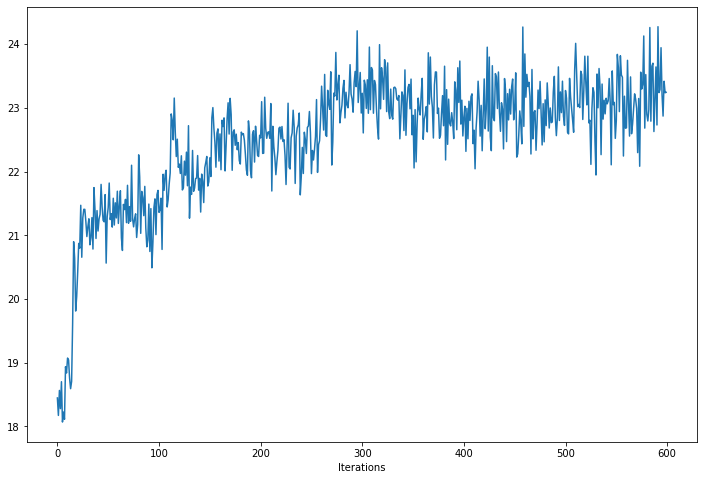

In [16]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=600,
    test_size=64,
    batch_size=32,
    hinge_param = 5,
    readj_interval=1,
    #gd_algorithm='rprop'
)

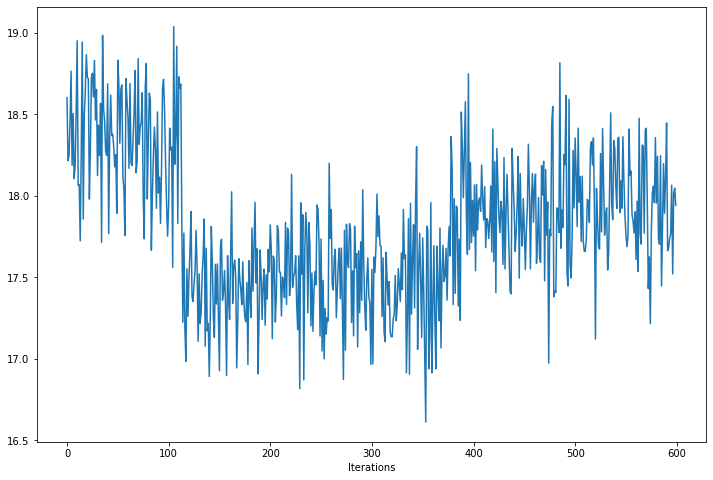

In [19]:
nm2 = NonlinearModel(df_sample,embeddings_50,size=8, embeddings_size=50, T=2)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=600,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    readj_interval=1,
    gd_algorithm='rprop'
)

### 3 Interest Units

In [34]:
nm.evaluate(df_sample_test,threshold=1000,max_len=500)

23.927526235580444 seconds to sort articles by rank.
Mean Average Precision: 0.001026662673924667
1.1735670566558838 seconds to evaluate.


669.4275741577148 seconds


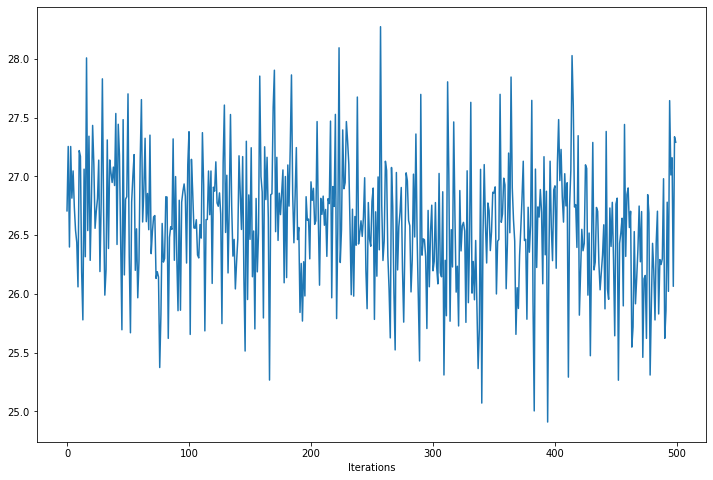

In [67]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=500,
    test_size=64,
    batch_size=48,
    hinge_param = 5,
    readj_interval=20,
    gd_algorithm='rprop'
)
print(time() - start, 'seconds')

641.7590608596802 seconds


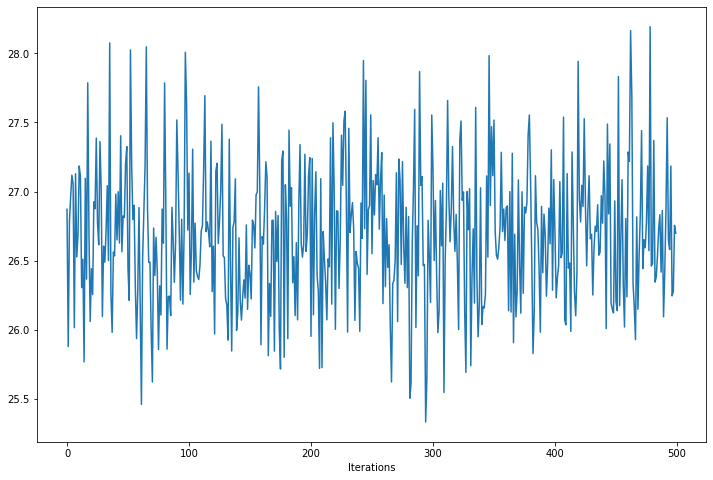

In [68]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=500,
    test_size=64,
    batch_size=48,
    hinge_param = -5,
    readj_interval=20,
    gd_algorithm='rprop'
)
print(time() - start, 'seconds')

641.4511320590973 seconds


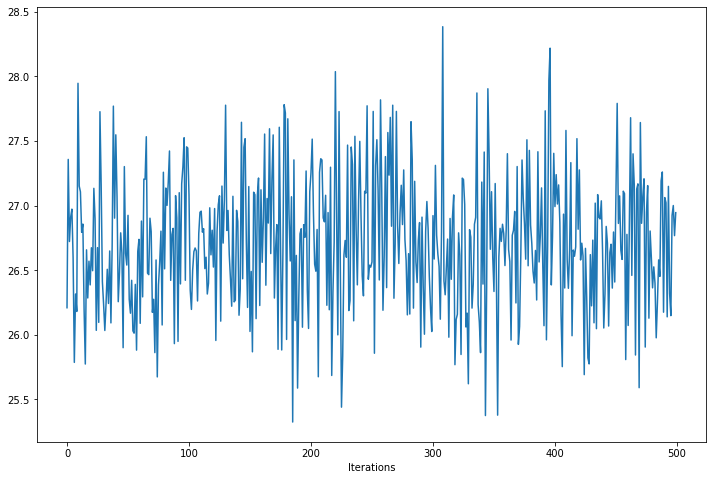

In [69]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=500,
    test_size=64,
    batch_size=48,
    hinge_param = 5,
    readj_interval=20,
    gd_algorithm='rprop'
)
print(time() - start, 'seconds')

675.7181100845337 seconds


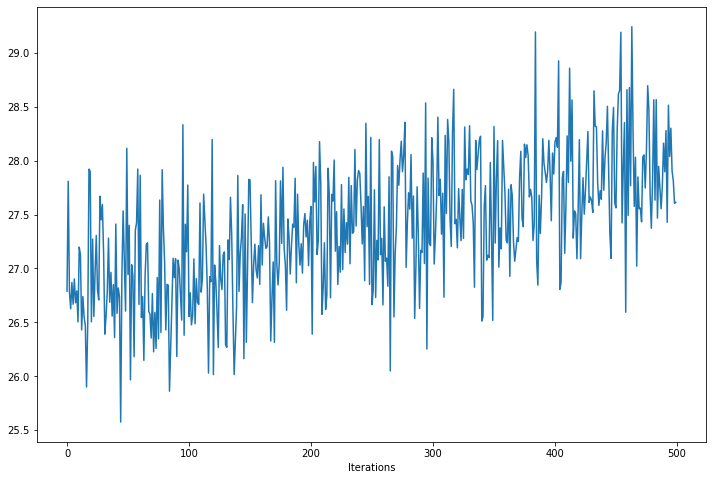

In [70]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.0001,
    max_iterations=500,
    test_size=64,
    batch_size=48,
    hinge_param = 25,
    readj_interval=1,
#     gd_algorithm='rprop'
)
print(time() - start, 'seconds')

7172.732901096344 seconds


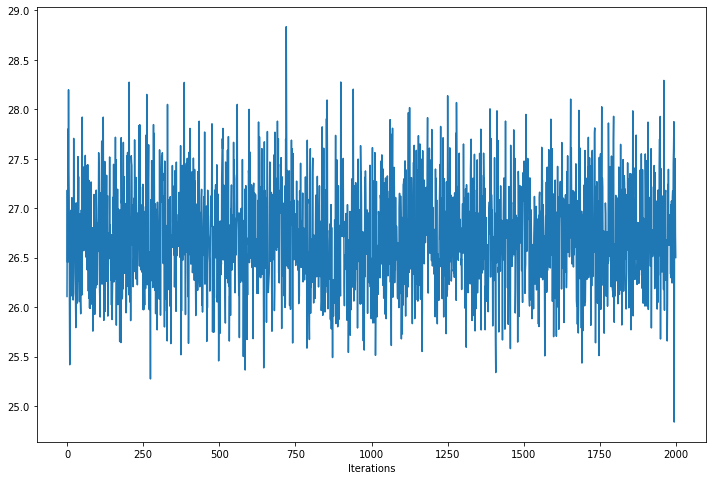

In [71]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.0001,
    max_iterations=2000,
    test_size=64,
    batch_size=96,
    hinge_param = 5,
    readj_interval=1,
#     gd_algorithm='rprop'
)
print(time() - start, 'seconds')

7012.472712755203 seconds


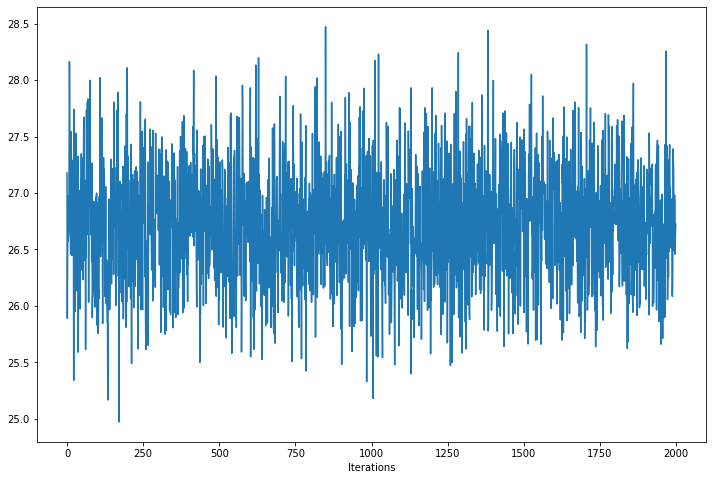

In [72]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.0001,
    max_iterations=2000,
    test_size=64,
    batch_size=96,
    hinge_param = -25,
    readj_interval=1,
#     gd_algorithm='rprop'
)
print(time() - start, 'seconds')

7017.322515964508 seconds


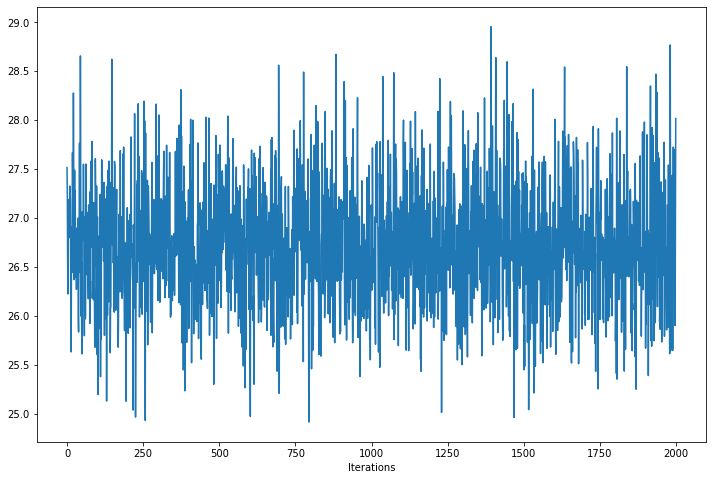

In [73]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.0001,
    max_iterations=2000,
    test_size=48,
    batch_size=96,
    hinge_param = -25,
    readj_interval=1,
#     gd_algorithm='rprop'
)
print(time() - start, 'seconds')